In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow --upgrade

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
  Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
vocab_size = 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

maxlen = 200
#Pad sequences:
print('Pad sequences (samples x time)')
input_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
input_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pad sequences (samples x time)
input_train shape: (25000, 200)
input_test shape: (25000, 200)


In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed-forward network inside the transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=False)
x = layers.GlobalAveragePooling1D()(x) # add global average pooling
x = layers.Dropout(0.3)(x) # add dropout
x = layers.Dense(20)(x) # add dense layer with about 20 neurons
x = layers.Dropout(0.3)(x) # add dropout
outputs = layers.Dense(2, activation='softmax')(x) # add the final dense layer for classification

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(input_train, y_train, batch_size=64, epochs=12, validation_data=(input_test, y_test))

Epoch 1/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.6409 - loss: 0.6348 - val_accuracy: 0.8387 - val_loss: 0.3857
Epoch 2/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8384 - loss: 0.3683 - val_accuracy: 0.8613 - val_loss: 0.3326
Epoch 3/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8965 - loss: 0.2643 - val_accuracy: 0.8584 - val_loss: 0.3412
Epoch 4/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9243 - loss: 0.2075 - val_accuracy: 0.8716 - val_loss: 0.3193
Epoch 5/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9375 - loss: 0.1654 - val_accuracy: 0.8735 - val_loss: 0.3228
Epoch 6/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9502 - loss: 0.1375 - val_accuracy: 0.8672 - val_loss: 0.3476
Epoch 7/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9571 - loss: 0.1169 - val_accuracy: 0.8676 - val_loss: 0.3911
Epoch 8/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9684 - loss: 0.0922 - val_

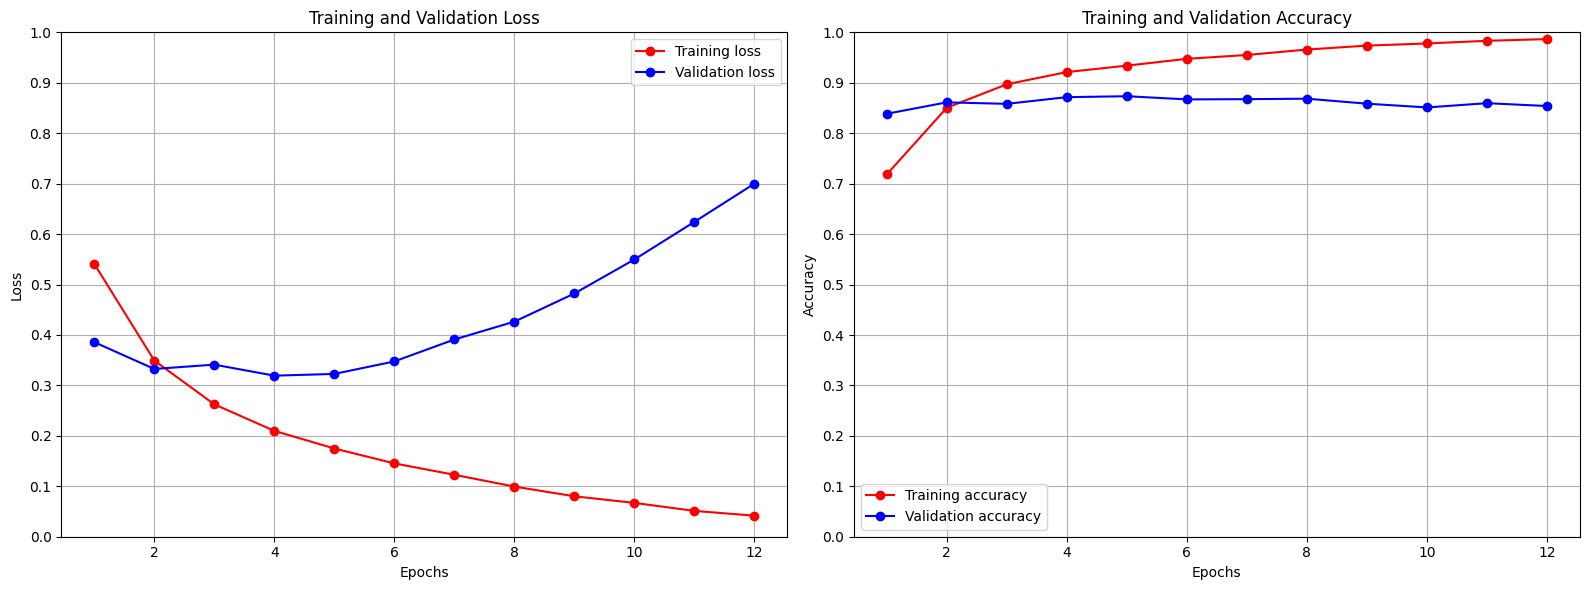

In [ ]:

history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.show()

In [2]:
!pip install --upgrade tensorflow==2.15.0

In [3]:
!pip install --quiet vit-keras
!pip install --quiet tensorflow-addons

from vit_keras import vit
import tensorflow_addons as tfa

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import  image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import os
import shutil
import random

In [5]:
def clone_and_prepare_dataset(github_repo='https://github.com/laxmimerit/dog-cat-full-dataset.git'):
    # Remove existing dataset directory if it exists
    if os.path.exists('dog-cat-full-dataset'):
        print("Removing existing directory 'dog-cat-full-dataset'...")
        shutil.rmtree('dog-cat-full-dataset')

    # Remove existing class directories if they exist
    for subset in ['train', 'validation', 'test']:
        if os.path.exists(subset):
            print(f"Removing existing '{subset}' directory...")
            shutil.rmtree(subset)

    print("Cloning the repository...")
    !git clone {github_repo}

    base_dir = 'dog-cat-full-dataset/data'
    print(f"Checking contents of base directory: {base_dir}")

    if os.path.exists(base_dir):
        print("Files in base directory:")
        print(os.listdir(base_dir))
    else:
        print(f"Directory {base_dir} does not exist.")
        return

    # Create target directories
    os.makedirs('train/cats', exist_ok=True)
    os.makedirs('train/dogs', exist_ok=True)
    os.makedirs('validation/cats', exist_ok=True)
    os.makedirs('validation/dogs', exist_ok=True)
    os.makedirs('test/cats', exist_ok=True)
    os.makedirs('test/dogs', exist_ok=True)

    cat_images = []
    dog_images = []

    for label in ['train', 'test']:
        for subdir in ['cats', 'dogs']:
            image_dir = os.path.join(base_dir, label, subdir)
            if os.path.exists(image_dir):
                images = os.listdir(image_dir)
                for img in images:
                    if subdir == 'cats':
                        cat_images.append(os.path.join(image_dir, img))
                    elif subdir == 'dogs':
                        dog_images.append(os.path.join(image_dir, img))

    print(f"Found {len(cat_images)} cat images and {len(dog_images)} dog images.")

    # Shuffle the lists to ensure randomness
    random.shuffle(cat_images)
    random.shuffle(dog_images)

    # Move images to train, validation, and test sets
    for i, img in enumerate(cat_images):
        if i < 1000:
            shutil.move(img, os.path.join('train/cats', os.path.basename(img)))
        elif i < 1500:  # Next 500 for validation
            shutil.move(img, os.path.join('validation/cats', os.path.basename(img)))
        elif i < 2000:  # Next 500 for test
            shutil.move(img, os.path.join('test/cats', os.path.basename(img)))

    for i, img in enumerate(dog_images):
        if i < 1000:
            shutil.move(img, os.path.join('train/dogs', os.path.basename(img)))
        elif i < 1500:  # Next 500 for validation
            shutil.move(img, os.path.join('validation/dogs', os.path.basename(img)))
        elif i < 2000:  # Next 500 for test
            shutil.move(img, os.path.join('test/dogs', os.path.basename(img)))

    print('Dataset cloned and organized into train, validation, and test sets!')

# Call the function to clone and prepare the dataset
clone_and_prepare_dataset()

Cloning the repository...
Cloning into 'dog-cat-full-dataset'...
remote: Enumerating objects: 25033, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 25033 (delta 0), reused 4 (delta 0), pack-reused 25027 (from 1)
Receiving objects: 100% (25033/25033), 541.85 MiB | 37.92 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (24990/24990), done.
Checking contents of base directory: dog-cat-full-dataset/data
Files in base directory:
['test', 'train']
Found 12500 cat images and 12489 dog images.
Dataset cloned and organized into train, validation, and test sets!


In [35]:
train_dataset = image_dataset_from_directory(
    '/content/train/',  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(224,224), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

val_dataset = image_dataset_from_directory(
    '/content/validation/',  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(224,224), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

test_dataset = image_dataset_from_directory(
    '/content/test/',  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(224,224), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

class_names = train_dataset.class_names
print(class_names)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['cats', 'dogs']


In [40]:
vit_model = vit.vit_b32(
        image_size = (224, 224),
        activation = 'softmax',#todo, softmax, sigmoid, etc. does not matter if you are not including top
        pretrained = True,
        include_top = False,
        pretrained_top = False)

In [41]:
model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(224, 224, 3)),
        vit_model,
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 dense_16 (Dense)            (None, 512)               393728    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 513       
                                                                 
Total params: 87849473 (335.12 MB)
Trainable params: 87849473 (335.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [43]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    batch_size=32,
    validation_data=val_dataset
)

Epoch 1/10
100/100 [==============================] - 70s 319ms/step - loss: 0.1563 - accuracy: 0.9430 - val_loss: 0.0733 - val_accuracy: 0.9740
Epoch 2/10
100/100 [==============================] - 29s 285ms/step - loss: 0.0549 - accuracy: 0.9795 - val_loss: 0.0944 - val_accuracy: 0.9630
Epoch 3/10
100/100 [==============================] - 29s 284ms/step - loss: 0.0772 - accuracy: 0.9735 - val_loss: 0.1345 - val_accuracy: 0.9540
Epoch 4/10
100/100 [==============================] - 29s 289ms/step - loss: 0.0450 - accuracy: 0.9830 - val_loss: 0.1025 - val_accuracy: 0.9710
Epoch 5/10
100/100 [==============================] - 29s 287ms/step - loss: 0.0320 - accuracy: 0.9895 - val_loss: 0.1245 - val_accuracy: 0.9590
Epoch 6/10
100/100 [==============================] - 29s 285ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.1557 - val_accuracy: 0.9690
Epoch 7/10
100/100 [==============================] - 29s 290ms/step - loss: 0.0244 - accuracy: 0.9930 - val_loss: 0.1228 - val_ac

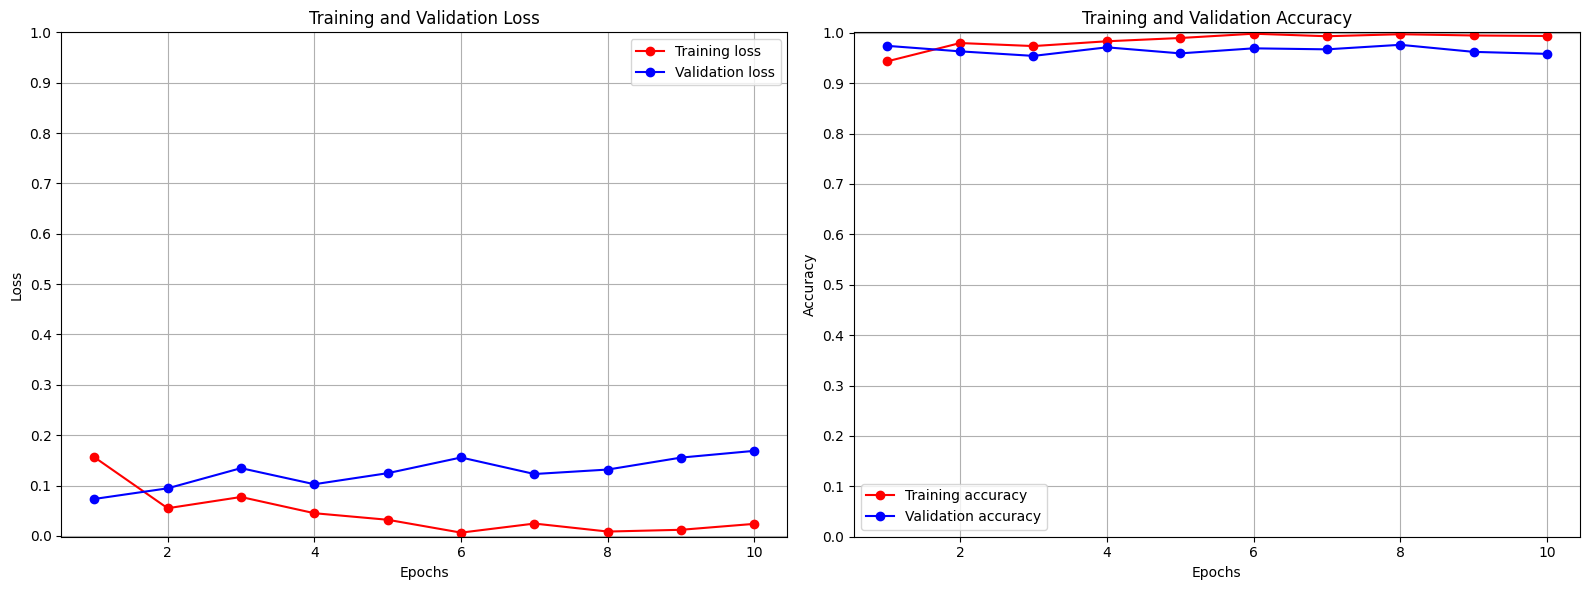

In [44]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.show()

1/1 [==============================] - 4s 4s/step
Prediction: mousetrap


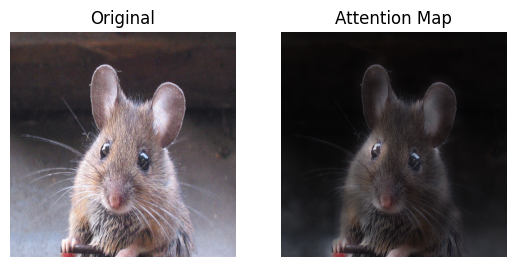

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from vit_keras import vit, utils, visualize

# Import dataset or ganaerate it using tf.data or ImageDataGenerator. Preprocess and augment the images.
classes = utils.get_imagenet_classes()
model = vit.vit_b16(
    image_size=384,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=True
)
classes = utils.get_imagenet_classes()

# Get an image and compute the attention map
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Apodemus_sylvaticus_bosmuis.jpg/1280px-Apodemus_sylvaticus_bosmuis.jpg'
image = utils.read(url, 384)
attention_map = visualize.attention_map(model=model, image=image)
print('Prediction:', classes[
    model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]
)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)